딥러닝세션 2차시 과제

In [24]:
import numpy as np # 행렬연산
import matplotlib.pyplot as plt # 시각화

import torch # 파이토치
import torch.nn as nn # 파이토치 모듈
import torch.nn.init as init # 초기화 관련 모듈 
import torch.optim as optim #최적화함수
from torch.utils.data import Dataset, DataLoader, random_split # 데이터셋을 학습에 용이하게 바꿈
import torch.nn.functional as F # 자주 쓰는 함수를 F로 따로 가져옴

batch_size = 1500
learning_rate = 0.01
num_epoch = 10

In [25]:
rawDataset = "log.csv"

class CSVDataset(Dataset):
    def __init__(self, file_path):
        data = np.loadtxt(file_path, delimiter=",", skiprows=1, dtype=np.float32)
        self.x = torch.tensor(data[:, :-1])  # 특성 데이터
        self.y = torch.tensor(data[:, -1])   # 타겟 데이터

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

dataset = CSVDataset(rawDataset)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [26]:
print(f"Train Dataset 크기: {len(train_dataset)}")
print(f"Test Dataset 크기: {len(test_dataset)}")

Train Dataset 크기: 7997
Test Dataset 크기: 2000


In [27]:
Data, Scores = next(iter(train_loader))

for score in Scores:
    print(score)

tensor(74.7547)
tensor(76.9533)
tensor(69.1061)
tensor(69.3030)
tensor(70.1988)
tensor(74.2351)
tensor(72.2371)
tensor(69.5393)
tensor(73.6909)
tensor(68.4517)
tensor(71.3144)
tensor(67.4013)
tensor(68.7458)
tensor(69.4169)
tensor(75.6250)
tensor(74.0418)
tensor(71.5497)
tensor(70.8411)
tensor(69.7262)
tensor(82.3267)
tensor(74.2531)
tensor(80.2674)
tensor(68.3770)
tensor(67.2365)
tensor(76.2302)
tensor(80.5308)
tensor(69.0119)
tensor(67.5050)
tensor(70.0613)
tensor(67.4005)
tensor(70.1014)
tensor(81.5580)
tensor(73.0527)
tensor(67.8428)
tensor(67.3741)
tensor(70.6039)
tensor(75.8560)
tensor(71.4296)
tensor(76.1689)
tensor(73.2816)
tensor(70.7376)
tensor(74.1082)
tensor(70.5766)
tensor(70.9774)
tensor(66.9286)
tensor(73.7051)
tensor(78.4772)
tensor(72.3419)
tensor(76.7474)
tensor(74.5584)
tensor(71.9216)
tensor(69.5349)
tensor(66.5826)
tensor(75.0577)
tensor(68.1846)
tensor(66.8968)
tensor(70.2256)
tensor(70.9633)
tensor(71.0269)
tensor(67.3424)
tensor(68.9538)
tensor(73.1063)
tensor(7

In [28]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # layer 생성
        self.fc1 = nn.Linear(5, 25) # ABCDE가 입력되니까 5
        self.fc2 = nn.Linear(25, 125)
        self.fc3 = nn.Linear(125, 25)
        self.fc4 = nn.Linear(25, 1)
        
        self.dropout = nn.Dropout(0.5) # 연산마다 50% 비율로 랜덤하게 노드 삭제... 나중에
        
        self.batch_norm1 = nn.BatchNorm1d(25) # 1dimension이기 때문에 BatchNorm1d를 사용함.
        self.batch_norm2 = nn.BatchNorm1d(125)
        self.batch_norm3 = nn.BatchNorm1d(25)
    
    
    def forward(self, x): # 모델의 연산 순서를 정의
    # 1st layer
        x = x.view(-1, 5)
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = F.relu(x) # activation function
        x = self.dropout(x)
    # 2nd layer
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.dropout(x)
    # 3rd layer
        x = self.fc3(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.dropout(x)
    # 4th layer
        x = self.fc4(x)
        return x

In [29]:
def weight_init(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight.data)

model= MLP()
model.apply(weight_init)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.3)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

In [30]:
def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (Data, Score) in enumerate(train_loader): # A,B,C,D,E, Score로 이루어진 train set
        optimizer.zero_grad() # 최적화 초기화
        output = model(Data) #  모델에 input을 넣어서 예측값을 구한다
        loss = loss_fn(output, Score) # 손실함수, error 계산
        loss.backward() # 손실 함수 기준으로 역전파 설정
        optimizer.step() # 역전파 진행 및 가중치 업데이트

In [31]:
def evaluate(model, Test):
    model.eval()
    loss = 0

    if Test:
        with torch.no_grad(): # 모델의 평가 단계이므로 gradient가 업데이트 되지 않도록 함
            for data, score in test_loader:
                output = model(data)
                loss += loss_fn(output, score).item() # loss 누적
                loss += torch.sqrt(loss_fn(output, score))
            loss /= len(test_loader.dataset) 
    else:
        with torch.no_grad(): # 모델의 평가 단계이므로 gradient가 업데이트 되지 않도록 함
            for data, score in train_loader:
                output = model(data)
                loss += loss_fn(output, score).item() # loss 누적
                loss += torch.sqrt(loss_fn(output, score))
            loss /= len(train_loader.dataset)
    return loss

In [ ]:
# 결과를 저장할 리스트
epoch_list = []
test_loss_list = []
train_loss_list = []

for epoch in range(1, num_epoch + 1):
    train(model, train_loader, optimizer)
    test_loss = evaluate(model, True)
    train_loss = evaluate(model, False)
    
    epoch_list.append(epoch)
    test_loss_list.append(test_loss)
    train_loss_list.append(train_loss)

    print("[EPOCH: {}], \tTest Loss(loss function): {:.4f}, \t Train loss(RSME): {:.6f} ".format(
        epoch, test_loss, train_loss
    ))

c:\Users\i-dle\anaconda3\envs\wetie_dl\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1500])) that is different to the input size (torch.Size([1500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\i-dle\anaconda3\envs\wetie_dl\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([497])) that is different to the input size (torch.Size([497, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\i-dle\anaconda3\envs\wetie_dl\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([500])) that is different to the input size (torch.Size([500, 1])). This will likely lead to incorrect results due to broadcasting. Please

TypeError: iteration over a 0-d tensor

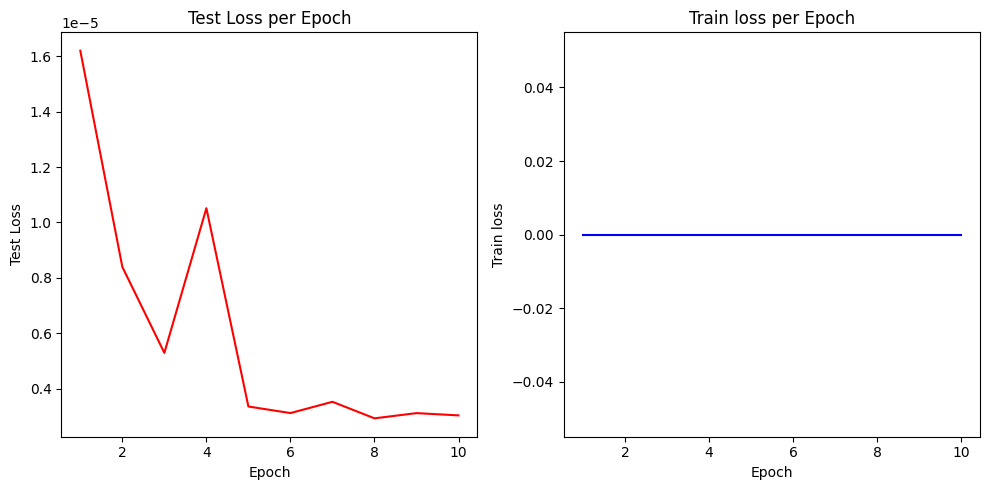

In [ ]:
# 시각화
plt.figure(figsize=(10, 5))

# Test Loss
plt.subplot(1, 2, 1)
plt.plot(epoch_list, test_loss_list, label='Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('Test Loss per Epoch')

# Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(epoch_list, train_loss_list, label='Train loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Train loss')
plt.title('Train loss per Epoch')

plt.tight_layout()
plt.show()